## Trabalho 1 -  MAE0326
TO-DO: 
* erro entre invariantes diminui ou converge?
* estimar Q

In [70]:
import numpy as np
from random import random, seed #uniforme

#geométrica normalizada que usamos em Q()
def normalized_geom(a, x, p):
    return (((1 - p)**(x-1))*p)/(1 - ((1-p)**(a-1))*p)


In [284]:
#Simulação
#Ideias: escolher aleatoriamente ou deixar em 0, 1
def generate_simulation(n, p, state=None):
    if (state != None):
        seed(state)
    sim = np.zeros((n + 100), dtype="int32")
    sim[0] = 1
    sim[1] = 1
    i = 2
    while i < n + 100:
        #pega uma uniforme
        target = random()
    
        #Q(ba, x)
        if (sim[i - 1] != sim[i - 2]):
            if (target < 1/2):
                sim[i] = sim[i - 1]
                continue
            acc = 1/2
            x = 0
            while (acc < target and x < 7):
                x += 1
                if (x == sim[i - 1]):
                    continue
                acc += 0.5 * normalized_geom(sim[i - 1], x, p)
            sim[i] = x
        #Q(aa, x)
        else:
            acc = 0
            x = 0
            while (acc < target and x < 7):
                x += 1
                if (x == sim[i - 1]):
                    continue
                acc += normalized_geom(sim[i - 1], x, p)
            sim[i] = x
        i += 1
    return sim[100:]
            
    

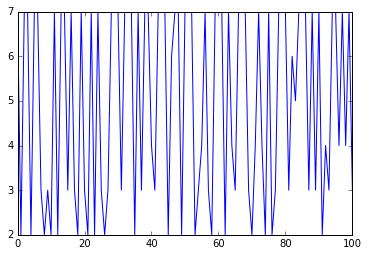

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(101), generate_simulation(101, 0.5, 0))
plt.show()

In [202]:
#estima medidas invariantes por contagem
def estimate_invariants(sim):
    return np.array([np.sum(sim == x) for x in range(max(sim))])[1:] / len(sim)

#calcula distancia entre invariantes, levando em conta que podem não ter o mesmo tamanho
def distance_invariants(pi_a, pi_b):
    minshape = min(pi_a.shape[0], pi_b.shape[0])
    dist = np.sum(np.abs(pi_a[:minshape] - pi_b[:minshape]))
    dist += np.sum(pi_a[minshape:]) + np.sum(pi_b[:minshape])
    return dist / max(pi_a.shape[0], pi_b.shape[0])

#estima invariantes do processo com p = p. Aumenta o tamanho da simulação até obter uma diferença menor que epsilon
def estimate_invariants_to_error(p, epsilon):
    delta = float('inf')
    #gera um estado aleatório para poder simular o mesmo processo a varios tamanhos
    state = random() 
    n = 1000
    base = generate_simulation(n, p, state)
    base_inv = estimate_invariants(base)
    while (delta > epsilon):
        prox = generate_simulation(n + 10, p, state)
        prox_inv = estimate_invariants(prox)
        
        delta = distance_invariants(base_inv, prox_inv)
        base = prox
        base_inv = prox_inv
        n = n + 1000
        if n == 1000000:
            break
        
    return base, base_inv, n, delta

In [203]:
sim, pi, n, err = estimate_invariants_to_error(0.5, 0.01)

KeyboardInterrupt: 

In [ ]:
print(n, err)

In [ ]:
from math import log, ceil
from collections import Counter

In [345]:

def estimate_matrix(sample):
    N = len(sample) + 1
    counter = Counter([sample[i - 3:i] for i in range(3, N)])
    context = Counter([sample[i - 2:i] for i in range(2, N - 1)])
    #print(counter)
    #print(context)
    matrix = dict()
    for key, value in counter.items():
        new_key = (key[0] + key[1]*10, key[2])
        matrix[new_key] = value/context[key[:2]] if context[key[:2]] != 0 else 0
    #print(matrix)
    max_s = max([key[0] for key in matrix]) + 1 #0 isnt used
    matrix_form = np.zeros((max_s, max(sample) + 1))
    for key, value in matrix.items():
        matrix_form[key] = value
        
    return matrix_form[1:, 1:]

def estimate_invariant(sample, eps, beta):
    n = int(ceil(log(eps)/log(1 - beta)))
    #print(n)
    N = len(sample) + 1
    n_grams = [(sample[i - n], sample[i - 1]) for i in range(n, N)]
    #print(n_grams)
    counter = Counter(n_grams)
    #print(counter)
    invariant = np.zeros((max(sample) + 1, 3))
    v = 0
    for key, value in counter.items():
        #print(value)
        invariant[key[1], :] = np.array([max(0,value/(N - n) - eps), min(1,value/(N - n) + eps), value/(N - n)])
        v += value
    print(v/(N - n))
    return invariant[1:, :] 

simulation = tuple(generate_simulation(1000, 1/2))
#print(simulation)
matrix = estimate_matrix(simulation)
#print(matrix)
invariant = estimate_invariant(simulation, 0.01, 1/4)
#print(invariant)

1.0


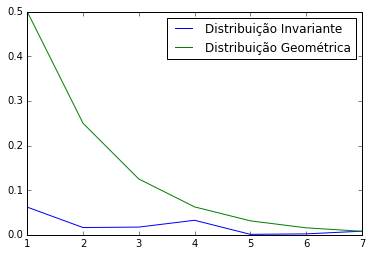

In [346]:
def geo(x):
    return 0.5*(0.5)**(x - 1)

plt.plot(np.arange(1, invariant.shape[0] + 1), invariant[:, 2], label="Distribuição Invariante")
plt.plot(np.arange(1, invariant.shape[0] + 1), [geo(i) for i in range(1, invariant.shape[0] + 1)], label="Distribuição Geométrica")
plt.legend()
plt.show()